In [ ]:
# Model Training & Evaluation – Customer Churn Prediction

## Objective
Train a cost-sensitive Random Forest model to predict customer churn,
evaluate its performance using business-relevant metrics, and explain
predictions using SHAP.

This notebook focuses on:
- Model training
- Handling class imbalance
- Model evaluation
- Explainability


In [6]:
#imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

sns.set_context("notebook")


In [7]:
DATA_PATH = "../data/churn_feature_engineered.csv"

df = pd.read_csv(DATA_PATH)
df.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,PaymentMethod,MonthlyCharges,TotalCharges,Churn,avg_monthly_spend,early_churn_risk,tenure_group,price_sensitivity,customer_value_score,service_count
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,Electronic check,29.85,29.85,0,14.925000,1,New,1.874411,29.85,1
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,Mailed check,56.95,1889.50,0,53.985714,0,Mid,1.035724,1936.30,3
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,Mailed check,53.85,108.15,1,36.050000,1,New,1.453441,107.70,3
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,Bank transfer (automatic),42.30,1840.75,0,40.016304,0,Loyal,1.031297,1903.50,3
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,Electronic check,70.70,151.65,1,50.550000,1,New,1.371484,141.40,1


In [8]:
#Separate Features & Target
X = df.drop("Churn", axis=1)
y = df["Churn"]

X.shape, y.shape


((7043, 25), (7043,))

In [9]:
#train/test split
_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

y_train.value_counts(normalize=True)


Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64

In [11]:
from sklearn.model_selection import train_test_split

X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [14]:
#encode categorical features

from sklearn.preprocessing import OneHotEncoder

cat_cols = X_train.select_dtypes(include="object").columns
num_cols = X_train.select_dtypes(exclude="object").columns

encoder = OneHotEncoder(drop="first", sparse_output=False)

X_train_cat = encoder.fit_transform(X_train[cat_cols])
X_test_cat = encoder.transform(X_test[cat_cols])

X_train_cat_df = pd.DataFrame(
    X_train_cat,
    columns=encoder.get_feature_names_out(cat_cols)
)

X_test_cat_df = pd.DataFrame(
    X_test_cat,
    columns=encoder.get_feature_names_out(cat_cols)
)

X_train_final = pd.concat(
    [
        X_train[num_cols].reset_index(drop=True),
        X_train_cat_df.reset_index(drop=True)
    ],
    axis=1
)

X_test_final = pd.concat(
    [
        X_test[num_cols].reset_index(drop=True),
        X_test_cat_df.reset_index(drop=True)
    ],
    axis=1
)

X_train_final.shape, X_test_final.shape


((5634, 38), (1409, 38))

In [15]:
#Train Random Forest (Cost-Sensitive)
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_leaf=20,
    class_weight="balanced",
    random_state=42
)

rf_model.fit(X_train_final, y_train)


,n_estimators,300
,criterion,'gini'
,max_depth,12
,min_samples_split,2
,min_samples_leaf,20
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [16]:
#Model Predictions
y_pred = rf_model.predict(X_test_final)
y_prob = rf_model.predict_proba(X_test_final)[:, 1]


In [18]:
#Evaluation Metrics
print("Classification Report:\n")
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")


Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1035
           1       0.53      0.78      0.63       374

    accuracy                           0.76      1409
   macro avg       0.72      0.76      0.72      1409
weighted avg       0.80      0.76      0.77      1409

ROC-AUC Score: 0.8454


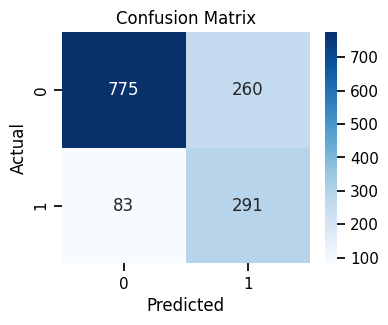

In [19]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


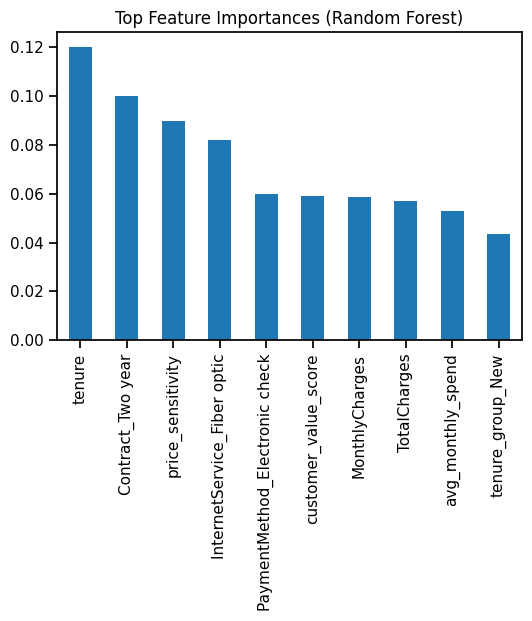

In [20]:
#Feature Importance (Model View)
feature_importance = pd.Series(
    rf_model.feature_importances_,
    index=X_train_final.columns
).sort_values(ascending=False)

feature_importance.head(10)
plt.figure(figsize=(6,4))
feature_importance.head(10).plot(kind="bar")
plt.title("Top Feature Importances (Random Forest)")
plt.show()


100%|===================| 2810/2818 [03:30<00:00]        

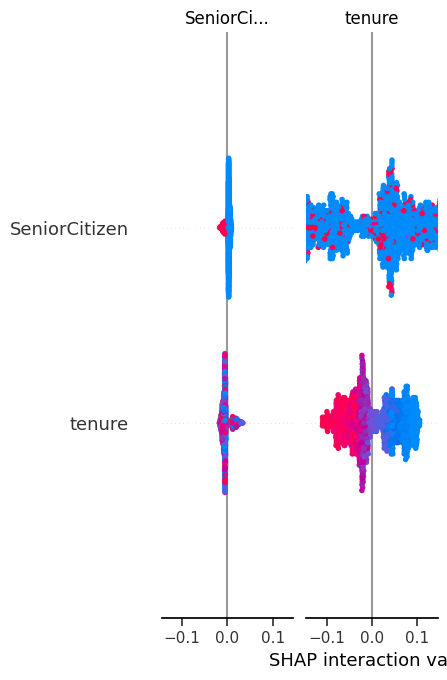

In [26]:
import shap

# Create explainer using training data as background
explainer = shap.Explainer(rf_model, X_train_final)

# Compute SHAP values for test data
shap_values = explainer(X_test_final)

# Summary plot (works without shape errors)
shap.summary_plot(shap_values.values, X_test_final)


In [29]:
#Risk Scoring & Segmentation
results = X_test_final.copy()
results["churn_probability"] = y_prob
results["actual_churn"] = y_test.values

results.head()
results["risk_segment"] = pd.cut(
    results["churn_probability"],
    bins=[0, 0.4, 0.7, 1.0],
    labels=["Low", "Medium", "High"]
)

results["risk_segment"].value_counts()


risk_segment
Low       739
Medium    376
High      294
Name: count, dtype: int64

In [30]:
# Save model outputs for retention simulation
model_results = X_test_final.copy()

model_results["churn_probability"] = y_prob
model_results["actual_churn"] = y_test.values

OUTPUT_PATH = "../data/model_results.csv"
model_results.to_csv(OUTPUT_PATH, index=False)

OUTPUT_PATH


'../data/model_results.csv'